---

<img src='../../../common/logo_DH.png' align='left' width=35%/>


## Datasets

En la práctica de la clase de hoy usaremos un **conjunto de propiedades** que tienen a la venta la inmobiliaria Properati: https://www.properati.com.ar/. Lo interesante es que a los datos clásicos de la propiedad (valor, superficie, barrio, tipo de propiedad), le agrega la posición geoespacial mediante su latitud y longitud.

Por otra parte, vamos a considerar a las **estaciones de subte**, donde tambien figuran el nombre y la línea a la que pertenece, y además, obviamente, sus datos geoposicionales.

## Ejercicio

Comenzamos leyendo los dos datasets en un *dataframe*, y lo transformamos en un *GeoDataFrame*. Es el tipo de datos que requiere GeoPandas para realizar operaciones con datos geoespaciales.

Luego vamos a *calcular la distancia* de cada propiedad al obelisco de Buenos Aires, y se registrará en una nueva columna. Haremos un cálculo para ver si existe alguna relacion entre esta distancia y el precio de la propiedad.

Finalmente *trazaremos una línea geométrica* con todas las estaciones de subte de una línea, y la graficaremos sobre la ciudad.

Alla vamos!

---

Importamos las bibliotecas que vamos a necesitar:

In [1]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

import shapely # genera las figuras geometricas
import descartes # relaciona shapely con matplotlib
import pyproj # proyecciones. Transformar coordenadas

### Parte 1 - Archivo de propiedades

Vamos a leer los datos del archivo /M1/CLASE_07/Data/properati_caba.csv en un `DataFrame` de pandas con el método `read_csv`. Lo llamaremos df_prop. 

*Nota:* los datos vienen separados por tabs. Se debe usar el parámetro <code>sep='\t'</code>

Ayuda:
https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.read_csv.html

In [8]:
data_location = "../Data/properati_caba.csv"
df_prop = pd.read_csv(data_location, encoding="latin1", sep="\t")
df_prop

,property_type,place_name,country_name,state_name,lat,lon,price,currency,surface_total_in_m2
0,PH,Mataderos,Argentina,Capital Federal,-34.661824,-58.508839,62000.0,USD,55.0
1,apartment,Mataderos,Argentina,Capital Federal,-34.652262,-58.522982,72000.0,USD,55.0
2,apartment,Belgrano,Argentina,Capital Federal,-34.559873,-58.443362,138000.0,USD,45.0
3,apartment,Belgrano,Argentina,Capital Federal,-34.559873,-58.443362,195000.0,USD,65.0
4,PH,Mataderos,Argentina,Capital Federal,-34.652356,-58.501624,239000.0,USD,140.0
...,...,...,...,...,...,...,...,...,...
17218,apartment,Barrio Norte,Argentina,Capital Federal,-34.599214,-58.402519,165000.0,USD,91.0
17219,apartment,Recoleta,Argentina,Capital Federal,-34.587425,-58.397372,165000.0,USD,44.0
17220,apartment,Belgrano,Argentina,Capital Federal,-34.563685,-58.442683,410000.0,USD,157.0
17221,apartment,Belgrano,Argentina,Capital Federal,-34.563685,-58.442683,410000.0,USD,157.0


- 1.a. Tomamos una muestra de 5 elementos

In [9]:
# 1.a
df_prop.sample(5)

,property_type,place_name,country_name,state_name,lat,lon,price,currency,surface_total_in_m2
15602,PH,Villa Real,Argentina,Capital Federal,-34.619840,-58.523697,159000.0,USD,125.0
4059,apartment,Recoleta,Argentina,Capital Federal,-34.586043,-58.396864,690000.0,USD,167.0
11710,apartment,Caballito,Argentina,Capital Federal,-34.612401,-58.443292,289000.0,USD,75.0
5283,apartment,Palermo Hollywood,Argentina,Capital Federal,-34.577306,-58.437252,74000.0,USD,29.0
16036,apartment,Monserrat,Argentina,Capital Federal,-34.619792,-58.381338,96100.0,USD,47.0


- 1.b. Cuántas propiedades son? Cuántas columnas tiene?

In [24]:
# 1.b
print("Propiedades:", df_prop.shape[0])
print("Columnas:", df_prop.shape[1])

Propiedades: 17223
Columnas: 9


- 1.c. Cuáles son las columnas? De qué tipo de datos son?

In [20]:
# 1.c
df_prop.dtypes

property_type           object
place_name              object
country_name            object
state_name              object
lat                    float64
lon                    float64
price                  float64
currency                object
surface_total_in_m2    float64
dtype: object

- 1.d. ¿Cuantas propiedades tenemos por barrio? El barrio figura en la columna *place_name*.

Ayuda:

    - Libro McKinney - Python for Data Analysis 2ed.pdf - capitulo 10 Data Aggregation and Group Operations

    - https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.value_counts.html?highlight=value_counts#pandas.Series.value_counts

In [28]:
# 1.d.
df_prop["place_name"].value_counts()

Palermo            1502
Belgrano           1496
Caballito          1389
Recoleta           1001
Flores              893
                   ... 
Parque Chas          15
Palermo Viejo        10
Villa Soldati         7
Villa Riachuelo       3
Catalinas             1
Name: place_name, Length: 62, dtype: int64

- 1.e. Las columnas *lat* y *lon* identifican la *latitud* y la *longitud* de la posición geoespacial de las propiedades. Pero necesitamos que la posición se exprese mediante la forma geométrica Punto, para poder trabajarlo desde GeoPandas.

Es decir que debemos transformar el DataFrame en un GeoDataFrame. Lo llamaremos *geo_prop*.

Pero para generar un GeoDataFrame, necesitamos agregar a las columnas del DataFrame una nueva columna que contenga una forma geométrica. Es este caso, un *punto*, el cual se genera a partir de la *latitud* y la *longitud*. 

Es recomendable que la nueva columna se llame *geometry*.

Con el método `gpd.points_from_xy` lo realizamos.

*Observar* que para definir el tipo *punto*, primero se ingresa la **longitud** y luego la **latitud**.

Ayuda:
https://geopandas.org/reference/geopandas.points_from_xy.html

In [29]:
# 1.e
geo_prop = gpd.GeoDataFrame(df_prop, geometry = gpd.points_from_xy(df_prop.lon, df_prop.lat))

Verificamos la nueva columna mirando las primeras filas

In [30]:
# 1.e
geo_prop.loc[:4, ['geometry', 'lat', 'lon','property_type','place_name']]

,geometry,lat,lon,property_type,place_name
0,POINT (-58.50884 -34.66182),-34.661824,-58.508839,PH,Mataderos
1,POINT (-58.52298 -34.65226),-34.652262,-58.522982,apartment,Mataderos
2,POINT (-58.44336 -34.55987),-34.559873,-58.443362,apartment,Belgrano
3,POINT (-58.44336 -34.55987),-34.559873,-58.443362,apartment,Belgrano
4,POINT (-58.50162 -34.65236),-34.652356,-58.501624,PH,Mataderos


---

### Parte 2 - Archivo de estaciones de subte

Vamos a leer los datos del archivo /M1/CLASE_07/Data/estaciones-de-subte.csv en un `DataFrame` de pandas con el método `read_csv`. Lo llamaremos df_subte.

*Nota:* los datos vienen separados por comas. Se debe usar el parámetro <code>sep=','</code>

In [32]:
data_loc = "../Data/estaciones-de-subte.csv"
df_subte = pd.read_csv(data_loc, encoding="latin1", sep=",")

- 2.a. Consultamos los primeros 10 registros

In [33]:
# 2.a.
df_subte.head(10)

,long,lat,id,estacion,linea
0,-58.398928,-34.635750,1.0,CASEROS,H
1,-58.400970,-34.629376,2.0,INCLAN - MEZQUITA AL AHMAD,H
2,-58.402323,-34.623092,3.0,HUMBERTO 1Â°,H
3,-58.404732,-34.615242,4.0,VENEZUELA,H
4,-58.406036,-34.608935,5.0,ONCE - 30 DE DICIEMBRE,H
5,-58.380574,-34.604245,6.0,9 DE JULIO,D
6,-58.397924,-34.599757,7.0,FACULTAD DE MEDICINA,D
7,-58.385142,-34.601587,8.0,TRIBUNALES - TEATRO COLÃN,D
8,-58.407161,-34.591628,9.0,AGÃERO,D
9,-58.415955,-34.585156,10.0,R.SCALABRINI ORTIZ,D


- 2.b. Cuántas estaciones son? Cuántas columnas tiene?

In [35]:
# 2.b.
print("Estaciones:", df_subte.shape[0])
print("Columnas:", df_subte.shape[1])

Estaciones: 90
Columnas: 5


- 2.c. Cuáles son las columnas? De qué tipo de datos son?

In [36]:
# 2.c.
df_subte.dtypes

long        float64
lat         float64
id          float64
estacion     object
linea        object
dtype: object

- 2.d. ¿Cuantas estaciones tenemos por línea?

Ayuda: es similar al punto 1.d

In [37]:
# 2.d.
df_subte["linea"].value_counts()

A    18
E    18
B    17
D    16
H    12
C     9
Name: linea, dtype: int64

- 2.e. Las columnas *lat* y *long* identifican la *latitud* y la *longitud* de la posición geoespacial de las propiedades. Pero necesitamos que la posición se exprese mediante la forma geométrica Punto, para poder trabajarlo desde GeoPandas.

Ayuda: es similar al punto 1.e

In [38]:
# 2.e.
geo_subte = gpd.GeoDataFrame(df_subte, geometry = gpd.points_from_xy(df_subte.long, df_subte.lat))

Verificamos la nueva columna mirando las primeras filas

In [39]:
geo_subte.head(5)

,long,lat,id,estacion,linea,geometry
0,-58.398928,-34.635750,1.0,CASEROS,H,POINT (-58.39893 -34.63575)
1,-58.400970,-34.629376,2.0,INCLAN - MEZQUITA AL AHMAD,H,POINT (-58.40097 -34.62938)
2,-58.402323,-34.623092,3.0,HUMBERTO 1Â°,H,POINT (-58.40232 -34.62309)
3,-58.404732,-34.615242,4.0,VENEZUELA,H,POINT (-58.40473 -34.61524)
4,-58.406036,-34.608935,5.0,ONCE - 30 DE DICIEMBRE,H,POINT (-58.40604 -34.60894)


---

### Parte 3 - Cálculo de la distancia

Vamos a calcular la **distancia de cada propiedad al obelisco de Buenos Aires**, y la registramos en una nueva columna.

Primero necesitamos representar el lugar geográfico del Obelisco de Buenos Aires. Lo hacemos mediante la forma geométrica *Punto*, y las cooordenadas del lugar. 

In [40]:
from shapely.geometry import Point

punto_obelisco_p = Point(-58.381555,-34.605425)

In [41]:
type(punto_obelisco_p)

shapely.geometry.point.Point

Pero el método que calcula la distancia entre dos puntos, <code>geopy.distance.geodesic</code>, necesita representar el lugar geográfico del Obelisco de Buenos Aires mediante una *tupla*.

In [42]:
punto_obelisco = (-58.381555,-34.605425)

In [43]:
type(punto_obelisco)

tuple

Ahora podemos agregar la nueva columna con la distancia entre el punto del obelisco y el punto de cada propiedad (en metros). La llamaremos *distancia_obelisco*. 

Se debe generar **una iteración** sobre el indice de geo_prop:

Ayuda:
<code>
for i in geo_prop.index:
    geo_prop.loc[i, 'distancia_obelisco'] = calculo distancia entre obelisco y cada propiedad.</code>
    
El cálculo se realiza con el método <code>geopy.distance.geodesic</code>, el cual se explica en la notebook 3_geopandas_operaciones.

Ademas con la sentencia <code>geo_prop.loc[i,'geometry'].x</code> obtenemos la coordenada longitud de la distancia.

Debe terminar con <code>.meters</code> para indicar la distancia en metros

Ver https://geopy.readthedocs.io/en/stable/#module-geopy.distance

In [44]:
geo_prop.index

RangeIndex(start=0, stop=17223, step=1)

In [45]:
# 3.a
import geopy.distance

for i in geo_prop.index:
    geo_prop.loc[i, 'distancia_obelisco'] = geopy.distance.geodesic(punto_obelisco,
                  (geo_prop.loc[i,'geometry'].x
                  ,geo_prop.loc[i,'geometry'].y)
                                                                   ).meters

Verificamos la nueva columna mirando las primeras filas

In [46]:
geo_prop.loc[:4, ['distancia_obelisco','geometry', 'lat', 'lon','property_type','place_name']]

,distancia_obelisco,geometry,lat,lon,property_type,place_name
0,14555.078219,POINT (-58.50884 -34.66182),-34.661824,-58.508839,PH,Mataderos
1,15988.570648,POINT (-58.52298 -34.65226),-34.652262,-58.522982,apartment,Mataderos
2,7381.316759,POINT (-58.44336 -34.55987),-34.559873,-58.443362,apartment,Belgrano
3,7381.316759,POINT (-58.44336 -34.55987),-34.559873,-58.443362,apartment,Belgrano
4,13651.907067,POINT (-58.50162 -34.65236),-34.652356,-58.501624,PH,Mataderos


Vamos a calcular una relación entre la distancia al obelisco y los precios de cada propiedad. 

Calculemos el promedio por barrio de la distancia y de los precios.Y luego hacemos un ranking de los promedios, y vemos si los primeros 10 rankeados de cada promedio son de los mismos barrios.

Para todos los calculos necesitamos usar el método **groupby**.

Primero se debe crear un nuevo GeoDataFrame con tantas filas como barrios tenemos.

In [75]:
geo_prop_group = geo_prop.groupby(['place_name']).count()

In [76]:
type(geo_prop_group)

geopandas.geodataframe.GeoDataFrame

In [77]:
geo_prop_group

,property_type,country_name,state_name,lat,lon,price,currency,surface_total_in_m2,geometry,distancia_obelisco
place_name,,,,,,,,,,
Abasto,59,59,59,59,59,59,59,59,59,59
AgronomÃ­a,25,25,25,25,25,25,25,25,25,25
Almagro,755,755,755,755,755,755,755,755,755,755
Balvanera,426,426,426,426,426,426,426,426,426,426
Barracas,309,309,309,309,309,309,309,309,309,309
...,...,...,...,...,...,...,...,...,...,...
Villa Riachuelo,3,3,3,3,3,3,3,3,3,3
Villa Santa Rita,26,26,26,26,26,26,26,26,26,26
Villa Soldati,7,7,7,7,7,7,7,7,7,7


Luego debemos agregar dos columnas con los promedios (distancia y precio) por barrio.

Ayuda:
<code>
geo_prop_group['nueva columna'] = geo_prop.groupby(['xxxxxxx'])[["yyyy"]].mean()
</code>

In [78]:
# 3.b. Promedio precios por barrio
geo_prop_group['precios_promedio'] = geo_prop.groupby(['place_name'])[["price"]].mean()
geo_prop_group

,property_type,country_name,state_name,lat,lon,price,currency,surface_total_in_m2,geometry,distancia_obelisco,precios_promedio
place_name,,,,,,,,,,,
Abasto,59,59,59,59,59,59,59,59,59,59,1.792157e+05
AgronomÃ­a,25,25,25,25,25,25,25,25,25,25,1.597952e+05
Almagro,755,755,755,755,755,755,755,755,755,755,2.383719e+05
Balvanera,426,426,426,426,426,426,426,426,426,426,1.667908e+05
Barracas,309,309,309,309,309,309,309,309,309,309,1.924282e+05
...,...,...,...,...,...,...,...,...,...,...,...
Villa Riachuelo,3,3,3,3,3,3,3,3,3,3,1.833333e+05
Villa Santa Rita,26,26,26,26,26,26,26,26,26,26,2.113846e+05
Villa Soldati,7,7,7,7,7,7,7,7,7,7,1.310730e+06


In [79]:
# 3.b.Promedio distancia por barrio
geo_prop_group['distancias_promedio'] = geo_prop.groupby(['place_name'])[["distancia_obelisco"]].mean()
geo_prop_group

,property_type,country_name,state_name,lat,lon,price,currency,surface_total_in_m2,geometry,distancia_obelisco,precios_promedio,distancias_promedio
place_name,,,,,,,,,,,,
Abasto,59,59,59,59,59,59,59,59,59,59,1.792157e+05,3366.178150
AgronomÃ­a,25,25,25,25,25,25,25,25,25,25,1.597952e+05,11496.658313
Almagro,755,755,755,755,755,755,755,755,755,755,2.383719e+05,4487.683052
Balvanera,426,426,426,426,426,426,426,426,426,426,1.667908e+05,2428.895604
Barracas,309,309,309,309,309,309,309,309,309,309,1.924282e+05,2152.119311
...,...,...,...,...,...,...,...,...,...,...,...,...
Villa Riachuelo,3,3,3,3,3,3,3,3,3,3,1.833333e+05,11034.007945
Villa Santa Rita,26,26,26,26,26,26,26,26,26,26,2.113846e+05,10786.585585
Villa Soldati,7,7,7,7,7,7,7,7,7,7,1.310730e+06,7454.006046


Y finalmente, agregar otras dos columnas con el ranking según el promedio (distancia y precio) por barrio.

Ayuda:
<code>
geo_prop_group["nueva columna rank"] = geo_prop_group.xxxxxxxx.rank(ascending=True)
</code>

In [97]:
# 3.b.Ranking distancia por barrio
geo_prop_group["distancias_promedio_rank"] = geo_prop_group.distancias_promedio.rank(ascending=True)
geo_prop_group

,property_type,country_name,state_name,lat,lon,price,currency,surface_total_in_m2,geometry,distancia_obelisco,precios_promedio,distancias_promedio,distancia_promedio_rank,precios_promedio_rank,distancias_promedio_rank
place_name,,,,,,,,,,,,,,,
Abasto,59,59,59,59,59,59,59,59,59,59,1.792157e+05,3366.178150,19.0,14.0,19.0
AgronomÃ­a,25,25,25,25,25,25,25,25,25,25,1.597952e+05,11496.658313,50.0,7.0,50.0
Almagro,755,755,755,755,755,755,755,755,755,755,2.383719e+05,4487.683052,23.0,39.0,23.0
Balvanera,426,426,426,426,426,426,426,426,426,426,1.667908e+05,2428.895604,15.0,10.0,15.0
Barracas,309,309,309,309,309,309,309,309,309,309,1.924282e+05,2152.119311,11.0,20.0,11.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Villa Riachuelo,3,3,3,3,3,3,3,3,3,3,1.833333e+05,11034.007945,46.0,15.0,46.0
Villa Santa Rita,26,26,26,26,26,26,26,26,26,26,2.113846e+05,10786.585585,44.0,29.0,44.0
Villa Soldati,7,7,7,7,7,7,7,7,7,7,1.310730e+06,7454.006046,34.0,62.0,34.0


In [108]:
# 3.b.Ranking precio por barrio
geo_prop_group["precios_promedio_rank"] = geo_prop_group.precios_promedio.rank(ascending=False)
geo_prop_group

,property_type,country_name,state_name,lat,lon,price,currency,surface_total_in_m2,geometry,distancia_obelisco,precios_promedio,distancias_promedio,distancia_promedio_rank,precios_promedio_rank,distancias_promedio_rank
place_name,,,,,,,,,,,,,,,
Abasto,59,59,59,59,59,59,59,59,59,59,1.792157e+05,3366.178150,19.0,49.0,19.0
AgronomÃ­a,25,25,25,25,25,25,25,25,25,25,1.597952e+05,11496.658313,50.0,56.0,50.0
Almagro,755,755,755,755,755,755,755,755,755,755,2.383719e+05,4487.683052,23.0,24.0,23.0
Balvanera,426,426,426,426,426,426,426,426,426,426,1.667908e+05,2428.895604,15.0,53.0,15.0
Barracas,309,309,309,309,309,309,309,309,309,309,1.924282e+05,2152.119311,11.0,43.0,11.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Villa Riachuelo,3,3,3,3,3,3,3,3,3,3,1.833333e+05,11034.007945,46.0,48.0,46.0
Villa Santa Rita,26,26,26,26,26,26,26,26,26,26,2.113846e+05,10786.585585,44.0,34.0,44.0
Villa Soldati,7,7,7,7,7,7,7,7,7,7,1.310730e+06,7454.006046,34.0,1.0,34.0


Verificamos las nuevas columnas

In [109]:
geo_prop_group.loc[:, ['precios_promedio','distancias_promedio','distancias_promedio_rank','precios_promedio_rank']]

,precios_promedio,distancias_promedio,distancias_promedio_rank,precios_promedio_rank
place_name,,,,
Abasto,1.792157e+05,3366.178150,19.0,49.0
AgronomÃ­a,1.597952e+05,11496.658313,50.0,56.0
Almagro,2.383719e+05,4487.683052,23.0,24.0
Balvanera,1.667908e+05,2428.895604,15.0,53.0
Barracas,1.924282e+05,2152.119311,11.0,43.0
...,...,...,...,...
Villa Riachuelo,1.833333e+05,11034.007945,46.0,48.0
Villa Santa Rita,2.113846e+05,10786.585585,44.0,34.0
Villa Soldati,1.310730e+06,7454.006046,34.0,1.0


Finalmente, observar si los primeros 10 rankeados de cada promedio son de los mismos barrios.

Primero hacerlo sobre el ranking de distancia, y luego sobre el ranking de precios.

Ayuda: https://pandas.pydata.org/pandas-docs/version/0.23.4/generated/pandas.DataFrame.sort_values.html

In [110]:
# 10 primeros rankeados por distancia
geo_prop_group.sort_values("distancias_promedio_rank").head(10)

,property_type,country_name,state_name,lat,lon,price,currency,surface_total_in_m2,geometry,distancia_obelisco,precios_promedio,distancias_promedio,distancia_promedio_rank,precios_promedio_rank,distancias_promedio_rank
place_name,,,,,,,,,,,,,,,
Catalinas,1,1,1,1,1,1,1,1,1,1,550000.000000,634.212781,1.0,6.0,1.0
Centro / Microcentro,190,190,190,190,190,190,190,190,190,190,237368.142105,680.202508,2.0,25.0,2.0
San NicolÃ¡s,118,118,118,118,118,118,118,118,118,118,190561.237288,693.926823,3.0,45.0,3.0
Tribunales,65,65,65,65,65,65,65,65,65,65,198811.830769,836.603422,4.0,37.0,4.0
Retiro,141,141,141,141,141,141,141,141,141,141,412255.000000,839.671966,5.0,11.0,5.0
Monserrat,265,265,265,265,265,265,265,265,265,265,199876.535849,888.232530,6.0,35.0,6.0
ConstituciÃ³n,154,154,154,154,154,154,154,154,154,154,164743.538961,1236.226130,7.0,54.0,7.0
San Telmo,573,573,573,573,573,573,573,573,573,573,506590.057592,1280.499050,8.0,7.0,8.0
Congreso,174,174,174,174,174,174,174,174,174,174,153215.413793,1382.937608,9.0,59.0,9.0


In [111]:
# 10 primeros rankeados por precio
geo_prop_group.sort_values("precios_promedio_rank").head(10)

,property_type,country_name,state_name,lat,lon,price,currency,surface_total_in_m2,geometry,distancia_obelisco,precios_promedio,distancias_promedio,distancia_promedio_rank,precios_promedio_rank,distancias_promedio_rank
place_name,,,,,,,,,,,,,,,
Villa Soldati,7,7,7,7,7,7,7,7,7,7,1.310730e+06,7454.006046,34.0,1.0,34.0
NuÃ±ez,384,384,384,384,384,384,384,384,384,384,1.164123e+06,9772.556382,41.0,2.0,41.0
Palermo Chico,146,146,146,146,146,146,146,146,146,146,1.100355e+06,3689.581743,20.0,3.0,20.0
Puerto Madero,364,364,364,364,364,364,364,364,364,364,9.774262e+05,2234.361297,12.0,4.0,12.0
Belgrano,1496,1496,1496,1496,1496,1496,1496,1496,1496,1496,5.778869e+05,8403.113119,37.0,5.0,37.0
Catalinas,1,1,1,1,1,1,1,1,1,1,5.500000e+05,634.212781,1.0,6.0,1.0
San Telmo,573,573,573,573,573,573,573,573,573,573,5.065901e+05,1280.499050,8.0,7.0,8.0
Recoleta,1001,1001,1001,1001,1001,1001,1001,1001,1001,1001,5.062143e+05,1779.484055,10.0,8.0,10.0
Boedo,278,278,278,278,278,278,278,278,278,278,4.437263e+05,4146.008502,22.0,9.0,22.0


In [115]:
barrios_cercanos = geo_prop_group.sort_values("distancias_promedio_rank").head(10).index
barrios_cercanos

Index(['Catalinas', 'Centro / Microcentro', 'San NicolÃ¡s', 'Tribunales',
       'Retiro', 'Monserrat', 'ConstituciÃ³n', 'San Telmo', 'Congreso',
       'Recoleta'],
      dtype='object', name='place_name')

In [117]:
barrios_precios_altos = geo_prop_group.sort_values("precios_promedio_rank").head(10).index
barrios_precios_altos

Index(['Villa Soldati', 'NuÃ±ez', 'Palermo Chico', 'Puerto Madero', 'Belgrano',
       'Catalinas', 'San Telmo', 'Recoleta', 'Boedo', 'Palermo'],
      dtype='object', name='place_name')

In [118]:
barrios_cercanos.intersection(barrios_precios_altos)
# Catalina, San Telmo y Recoleta están dentro de los 10 barrios más cercanos al Obelisco y dentro de los 10 barrios más caros.

Index(['Catalinas', 'San Telmo', 'Recoleta'], dtype='object', name='place_name')

### Parte 4 - Línea que una a las estaciones de subte

Vamos a hacer una línea geométrica con las estaciones de subte de la línea H y graficarla sobre la ciudad.

<div>
    <div class = "mapa">
        <img src='img/M1_Clase_07_1_desafio.jpg' alt="Elementos geométricos" width=80% height=90%>
    </div>
</div>

In [119]:
geo_subte.head(4)

,long,lat,id,estacion,linea,geometry
0,-58.398928,-34.635750,1.0,CASEROS,H,POINT (-58.39893 -34.63575)
1,-58.400970,-34.629376,2.0,INCLAN - MEZQUITA AL AHMAD,H,POINT (-58.40097 -34.62938)
2,-58.402323,-34.623092,3.0,HUMBERTO 1Â°,H,POINT (-58.40232 -34.62309)
3,-58.404732,-34.615242,4.0,VENEZUELA,H,POINT (-58.40473 -34.61524)


Primero seleccionemos solo las estaciones de la linea H, y guardamos la selección en la variable geo_subte_h.

In [122]:
geo_subte_h = geo_subte[geo_subte.linea == "H"]

In [123]:
geo_subte_h

,long,lat,id,estacion,linea,geometry
0,-58.398928,-34.635750,1.0,CASEROS,H,POINT (-58.39893 -34.63575)
1,-58.400970,-34.629376,2.0,INCLAN - MEZQUITA AL AHMAD,H,POINT (-58.40097 -34.62938)
2,-58.402323,-34.623092,3.0,HUMBERTO 1Â°,H,POINT (-58.40232 -34.62309)
3,-58.404732,-34.615242,4.0,VENEZUELA,H,POINT (-58.40473 -34.61524)
4,-58.406036,-34.608935,5.0,ONCE - 30 DE DICIEMBRE,H,POINT (-58.40604 -34.60894)
76,-58.405450,-34.604490,77.0,CORRIENTES,H,POINT (-58.40545 -34.60449)
77,-58.405795,-34.638406,78.0,PARQUE PATRICIOS,H,POINT (-58.40579 -34.63841)
78,-58.412385,-34.641269,79.0,HOSPITALES,H,POINT (-58.41239 -34.64127)
83,-58.403721,-34.598455,84.0,CÃRDOBA,H,POINT (-58.40372 -34.59846)
84,-58.397216,-34.587462,85.0,LAS HERAS,H,POINT (-58.39722 -34.58746)


Como muestra el dibujo, la línea corre de Norte a Sur (o Sur a Norte). Como las estaciones deben estar alineadas para que salga bien la línea, podemos usar la columna lat para ordenarlas; lat es la latitud de cada estación.

Ayuda: considerar sort_values con by
https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.sort_values.html

In [136]:
geo_subte_h = geo_subte_h.sort_values("lat", ascending=False)

In [137]:
geo_subte_h

,long,lat,id,estacion,linea,geometry
86,-58.391019,-34.583036,87.0,FACULTAD DE DERECHO - JULIETA LANTERI,H,POINT (-58.39102 -34.58304)
84,-58.397216,-34.587462,85.0,LAS HERAS,H,POINT (-58.39722 -34.58746)
85,-58.402376,-34.594525,86.0,SANTA FE - CARLOS JAUREGUI,H,POINT (-58.40238 -34.59453)
83,-58.403721,-34.598455,84.0,CÃRDOBA,H,POINT (-58.40372 -34.59846)
76,-58.405450,-34.604490,77.0,CORRIENTES,H,POINT (-58.40545 -34.60449)
4,-58.406036,-34.608935,5.0,ONCE - 30 DE DICIEMBRE,H,POINT (-58.40604 -34.60894)
3,-58.404732,-34.615242,4.0,VENEZUELA,H,POINT (-58.40473 -34.61524)
2,-58.402323,-34.623092,3.0,HUMBERTO 1Â°,H,POINT (-58.40232 -34.62309)
1,-58.400970,-34.629376,2.0,INCLAN - MEZQUITA AL AHMAD,H,POINT (-58.40097 -34.62938)
0,-58.398928,-34.635750,1.0,CASEROS,H,POINT (-58.39893 -34.63575)


Para simplificar la codificación, solo nos quedaremos con los datos geográficos de cada estación.

Generamos una *GeoSeries* con la columna geometry de geo_subte_h. Y la llamamos geo_subte_h_geometry.

In [138]:
geo_subte_h_geometry = gpd.GeoSeries(geo_subte_h.geometry)
geo_subte_h_geometry

86    POINT (-58.39102 -34.58304)
84    POINT (-58.39722 -34.58746)
85    POINT (-58.40238 -34.59453)
83    POINT (-58.40372 -34.59846)
76    POINT (-58.40545 -34.60449)
4     POINT (-58.40604 -34.60894)
3     POINT (-58.40473 -34.61524)
2     POINT (-58.40232 -34.62309)
1     POINT (-58.40097 -34.62938)
0     POINT (-58.39893 -34.63575)
77    POINT (-58.40579 -34.63841)
78    POINT (-58.41239 -34.64127)
Name: geometry, dtype: geometry

Ahora creamos las líneas que unen a las estaciones de subte. 

Cada línea se forma con **dos puntos**. Por lo tanto, tenemos que tomar el primer y segundo punto de la Geoserie, y aplicarles el método <code>LineString</code>. Luego seguimos con el segundo y el tercero, y así siguiendo.

*Primero creamos una lista donde guardaremos cada linea.* La llamamos linea_h. Debe tener una longitud igual a la cantidad de estaciones menos 1, es decir longitud 11.

In [143]:
longitud_linea = len(geo_subte_h_geometry)-1
linea_h = list(range(longitud_linea))
linea_h, longitud_linea

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10], 11)

Ahora podemos crear las líneas y guardarlas en la lista.

Se debe generar **una iteración** para recorrer la GeoSerie *geo_subte_h_geometry*.

Ayuda:
<code>
for i in range(longitud_linea): 
    linea_h[i] = creo la linea entre el elemento i y el elemento i+1
</code> 
    
El cálculo se realiza con el método <code>LineString</code> de la libreria shapely, el cual se explica en la notebook 3_geopandas_operaciones.

In [146]:
from shapely.geometry import LineString

for i in range(longitud_linea): 
    point1 = (geo_subte_h_geometry.iloc[i].x, geo_subte_h_geometry.iloc[i].y)
    point2 = (geo_subte_h_geometry.iloc[i+1].x, geo_subte_h_geometry.iloc[i+1].y)
    linea_h[i] = LineString([point1, point2]) # No olvidar los corchetes!

---

Ahora vamos a graficar las líneas sobre un mapa con los barrios de Buenos Aires.

Vamos a leer los datos del archivo /M1/CLASE_07/Data/barrios.csv en un `DataFrame` de pandas con el método `read_csv`. Lo llamaremos df_barrios.

In [147]:
data_loc = "../Data/barrios.csv"
df_barrios = pd.read_csv(data_loc, encoding="latin1")
df_barrios.head()

,WKT,BARRIO,COMUNA,PERIMETRO,AREA
0,"POLYGON ((-58.4528200492791 -34.5959886570639,...",CHACARITA,15.0,7725.695228,3.118101e+06
1,"POLYGON ((-58.4655768128541 -34.5965577078058,...",PATERNAL,15.0,7087.513295,2.229829e+06
2,"POLYGON ((-58.4237529813037 -34.5978273383243,...",VILLA CRESPO,15.0,8132.699348,3.613584e+06
3,"POLYGON ((-58.4946097568899 -34.6148652395239,...",VILLA DEL PARQUE,11.0,7705.389797,3.399596e+06
4,"POLYGON ((-58.4128700313089 -34.6141162515854,...",ALMAGRO,5.0,8537.901368,4.050752e+06


---

Y luego generamos un GeoDataFrame de los barrios a partir del Dataframe. En este caso, la columna WKT ya contiene una forma geométrica **polígono** que representa el contorno de cada barrio. Pero en un formato WKT, que no permite generar un GeoDataFrame. Por lo tanto, lo tenemos que convertir a un formato *geometry*.

In [148]:
import shapely.wkt

df_barrios["WKT"] = df_barrios["WKT"].apply(shapely.wkt.loads) 
geo_barrios = gpd.GeoDataFrame(df_barrios, geometry='WKT')

Por otra parte, necesitamos para graficar las líneas generar una GeoSerie donde cada elemento se compone de dos puntos y la línea entre ellos.

In [149]:
linea_h_geo = list(range(longitud_linea))

for i in range(longitud_linea): 
    linea_h_geo[i] = gpd.GeoSeries([geo_subte_h_geometry.iloc[i], geo_subte_h_geometry.iloc[i+1], linea_h[i]])

Con el método plot generamos el gráfico:

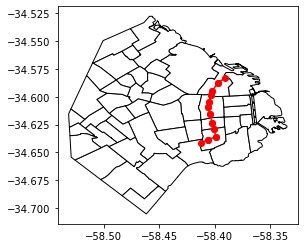

In [151]:
fig, ax = plt.subplots()
ax.set_aspect('equal')
geo_barrios.plot(ax=ax, color='white', edgecolor='black')

for i in range(len(geo_subte_h_geometry)-1): 
    linea_h_geo[i].plot(ax=ax, color='red')

plt.show();